# Part 2: Use existing SiebenApp structures

In [1]:
# Rendering defaults
WIDTH = 3

In [2]:
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Set, Union, Optional
from dataclasses import dataclass, field, replace
from enum import IntEnum

In SiebenApp, we use the following structures in rendering algorithm:

In [3]:
# One of two supported edge types
class EdgeType(IntEnum):
    BLOCKER = 1
    PARENT = 2

# Edge between two goals (wow, it doesn't use GoalId, right?)
@dataclass(frozen=True)
class Edge:
    source: int
    target: int
    type: EdgeType

# For leegacy reasons, goal id may be either integer (real or pseudo goal) or string (pseudo goal only)
GoalId = Union[str, int]

# Single row of "render result" (well, actually, it's a single goal)
@dataclass(frozen=True)
class RenderRow:
    """Strongly typed rendered representation of a single goal."""

    goal_id: GoalId
    raw_id: int
    name: str
    is_open: bool
    is_switchable: bool
    edges: list[tuple[GoalId, EdgeType]]
    attrs: dict[str, str] = field(default_factory=lambda: {})

# A whole result of "rendering" (also suitable for result returned by a single request to goal tree)
@dataclass
class RenderResult:
    rows: list[RenderRow]
    edge_opts: dict[str, tuple[int, int, int]]
    select: tuple[GoalId, GoalId]
    node_opts: dict[GoalId, Any]
    roots: set[GoalId]
    index: dict[GoalId, int]

    def __init__(
        self,
        rows: list[RenderRow],
        edge_opts: Optional[dict[str, tuple[int, int, int]]] = None,
        select: Optional[tuple[GoalId, GoalId]] = None,
        node_opts: Optional[dict[GoalId, Any]] = None,
        roots: Optional[set[GoalId]] = None,
    ):
        self.rows = rows
        self.edge_opts = edge_opts or {}
        self.select = select or (0, 0)
        self.node_opts = node_opts or {}
        self.roots = roots or set()
        self.index = {row.goal_id: i for i, row in enumerate(rows)}

    def goals(self):
        return [
            (goal_id, attrs)
            for goal_id, attrs in self.node_opts.items()
            if isinstance(goal_id, int)
        ]

    def by_id(self, goal_id: GoalId) -> RenderRow:
        assert goal_id in self.index
        return self.rows[self.index[goal_id]]


Our goal is to recreate algorithm above using these structures, not just raw dicts.

In [4]:
from random import randint

In [6]:
# Some example graph
edges = {
    1: [8, 10, 12, 13],
    2: [5],
    3: [6],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [11],
    11: [3],
    12: [2, 4, 14],
    13: [7, 9],
    14: [],
}

sample_result = RenderResult(
    [
        RenderRow(k, k, f"Goal {k}", True, not es,
                  [(e, EdgeType.PARENT) for e in es], {})
        for k, es in edges.items()
    ],
    node_opts={k: {} for k in edges},
    select=(1, 1),
    roots={1},
)

In [7]:
sample_result

RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(g

In [8]:
def draw(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        # print(goal_id, row, col)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    # print(xpos)
    # print(ypos)
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

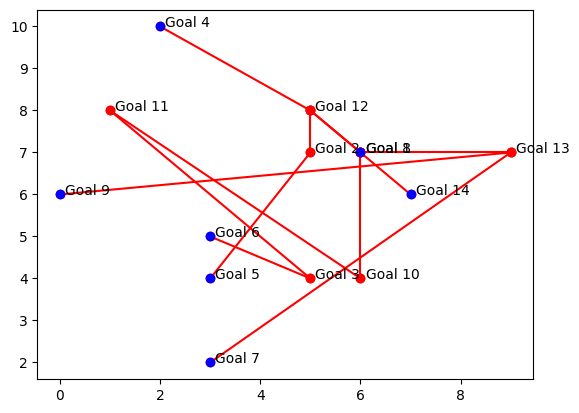

In [9]:
draw(sample_result)

In [11]:
def add_if_not(m: Dict, m1: Dict) -> Dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

def tube(rr: RenderResult, roots: List[int], layers: List[List[int]]):
    new_layer: List[int] = roots[:WIDTH]
    new_roots: List[int] = roots[len(new_layer):] + [e[0] for gid in new_layer for e in rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in rr.node_opts.items()
    }
    
    return RenderResult(rr.rows, node_opts=new_opts, select=rr.select, roots=rr.roots), new_roots, layers + [new_layer]

In [12]:
rr1, roots1, layers1 = tube(sample_result, list(sample_result.roots), [])
rr1, roots1, layers1

(RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(

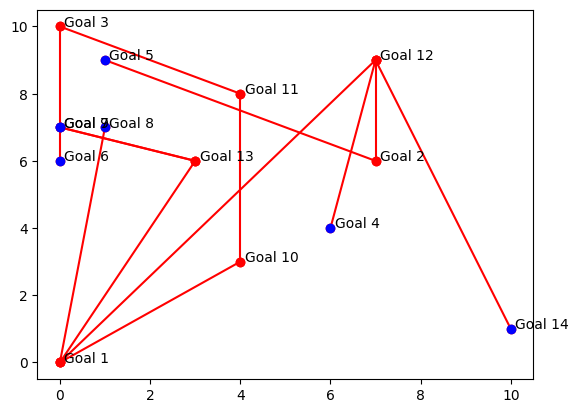

In [13]:
draw(rr1, min_row=1)

In [14]:
rr2, roots2, layers2 = tube(rr1, roots1, layers1)
rr2, roots2, layers2

(RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='Goal 1', is_open=True, is_switchable=False, edges=[(8, <EdgeType.PARENT: 2>), (10, <EdgeType.PARENT: 2>), (12, <EdgeType.PARENT: 2>), (13, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='Goal 2', is_open=True, is_switchable=False, edges=[(5, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='Goal 3', is_open=True, is_switchable=False, edges=[(6, <EdgeType.PARENT: 2>)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='Goal 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='Goal 5', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=6, raw_id=6, name='Goal 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='Goal 7', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=8, raw_id=8, name='Goal 8', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(

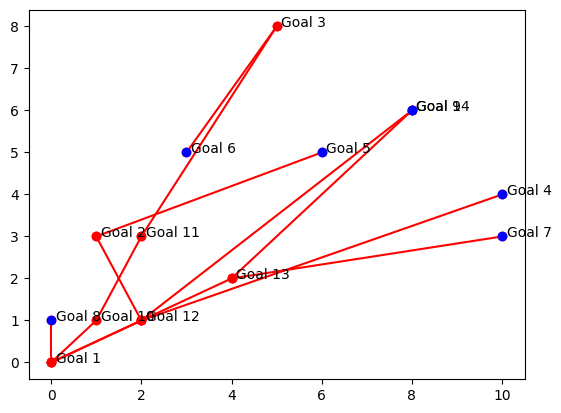

In [15]:
draw(rr2, min_row=2)

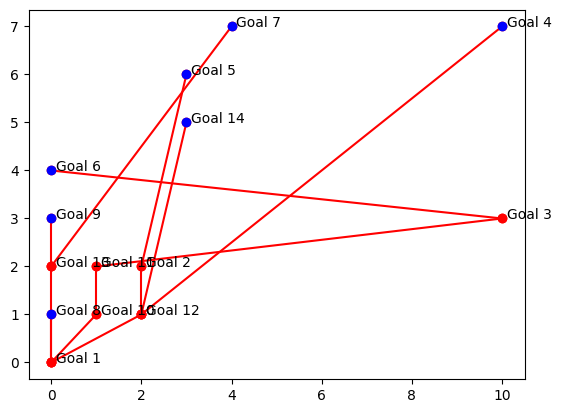

In [17]:
rr3, roots3, layers3 = tube(rr2, roots2, layers2)
draw(rr3, min_row=3)

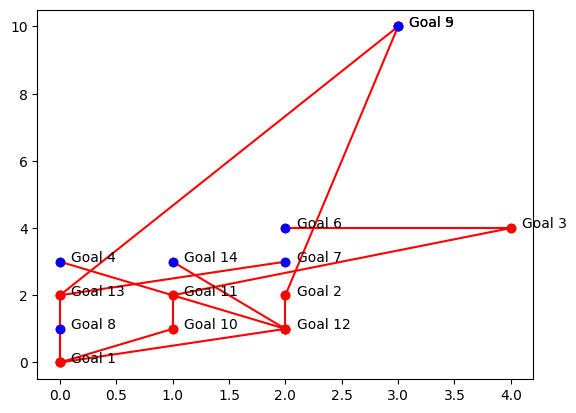

In [18]:
rr4, roots4, layers4 = tube(rr3, roots3, layers3)
draw(rr4, min_row=4)

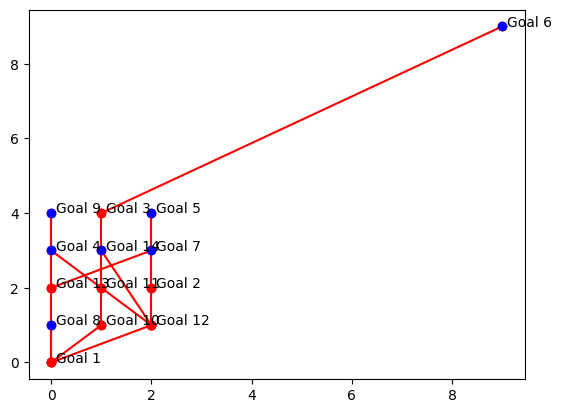

In [19]:
rr5, roots5, layers5 = tube(rr4, roots4, layers4)
draw(rr5, min_row=6)

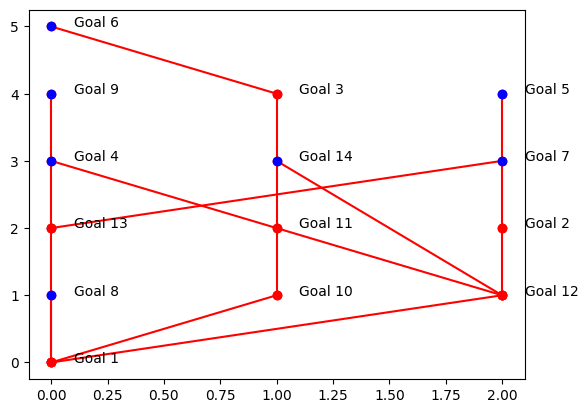

In [20]:
rr6, roots6, layers6 = tube(rr5, roots5, layers5)
draw(rr6)

In [21]:
roots6, layers6

([], [[1], [8, 10, 12], [13, 11, 2], [4, 14, 7], [9, 3, 5], [6]])

Variable `roots6` is empty, so we've finished.

To summarize, we need a following fn to put all goals onto layers:

In [22]:
def split_to_layers(rr: RenderResult) -> RenderResult:
    roots = list(rr.roots)
    layers = []
    while roots:
        rr, roots, layers = tube1(rr, roots, layers)
    return rr

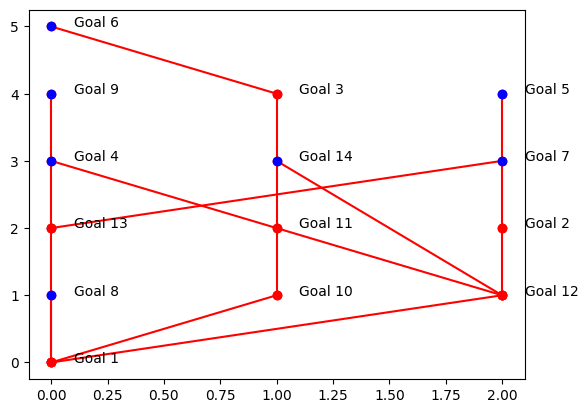

In [24]:
sample_with_layers = split_to_layers(sample_result)
draw(sample_with_layers)